In [1]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
from math import floor

# Data Pre Processing

In [2]:
# Get a list of image paths
masks = glob.glob("./ISIC2018_Task1_Training_GroundTruth_x2/*.png")
images = glob.glob("./ISIC2018_Task1_2_Training_Input_x2/*.jpg")

In [3]:
# Sort the images, as glob doesn't gaurentee same ordering as files
masks.sort()
images.sort()
# Convert the list of strings into a 1d  string tensor
masksTf = tf.data.Dataset.from_tensor_slices(masks)
imagesTf = tf.data.Dataset.from_tensor_slices(images)

In [4]:
def load_jpeg(image):
    # Load the image turn into jpeg
    decoded = tf.io.read_file(image)
    imageTf = tf.image.decode_jpeg(decoded)
    return imageTf

def load_png(image):
    # Load the image turn into png
    decoded = tf.io.read_file(image)
    imageTf = tf.image.decode_png(decoded)
    return imageTf

In [5]:
masksTfImages = masksTf.map(load_png)
imagesTfImages = imagesTf.map(load_jpeg)

In [6]:
# Plots a given image and mask
def display(image, mask):
    plt.figure(figsize=(15, 15))
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
    plt.axis("off")
    plt.show()

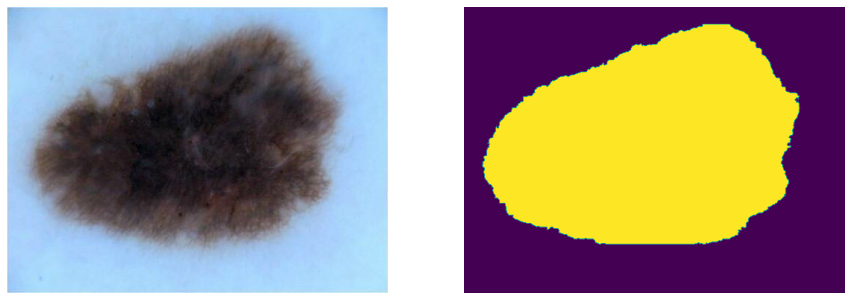

In [7]:
# Plot the images, namely to see if the tensors are properly configured
for imageTf in imagesTfImages.take(1):
    image = imageTf
for maskTf in masksTfImages.take(1):
    mask = maskTf

display(image, mask)

In [8]:
#Find the smallest image dimensions, and whether those dimensions are from seperate or the same image. 
minx = miny = 10000
seperate_images = True
for image in imagesTfImages:
    minxUpdated = False
    if image.shape[0] < minx:
        minx = image.shape[0]
        minxUpdated = True
    if image.shape[1] < miny:
        miny = image.shape[1]
        if minxUpdated:
            seperate_images = False
        
print(f"Min x: {minx}. Min y: {miny}. Seperate Images: {seperate_images}")

Min x: 270. Min y: 288. Seperate Images: False


In [9]:
# Reshape every image to have either those dimensions or a custom number. Include padding as position of the lesions may be important in classification
def resizeImages(image):
    return tf.image.resize_with_pad(image, 488, 488)

imagesResized = imagesTfImages.map(resizeImages)
masksResized = masksTfImages.map(resizeImages)

(488, 488, 3)


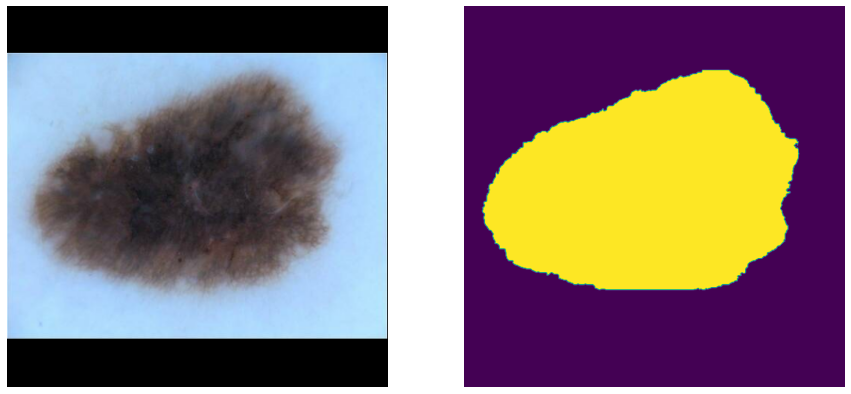

In [10]:
# Plot an image, check to se how they look after resize
for imageTf in imagesResized.take(1):
    imagePlot = imageTf
    print(imageTf.shape)
for maskTf in masksResized.take(1):
    maskPlot = maskTf
    
display(imagePlot, maskPlot)

In [11]:
# Count the number of pixels that aren't 0. This implicity gives starting pixel location of mask.
def nonZeroCount(image):
    # Counts the number of non zero pixels
    rowNonZero = tf.math.count_nonzero(image, axis=0)
    colNonZero = tf.math.count_nonzero(image, axis=1)
    # Flattens the tensors to be a list
    rowNonZeroList = tf.reshape(rowNonZero, [-1])
    colNonZeroList = tf.reshape(colNonZero, [-1])
    return rowNonZeroList, colNonZeroList

# Get index of first non zero given list of values
def firstNonZero(boolList):
    firstTrue = -1
    for pos in boolList:
        firstTrue += 1
        if pos != 0:
            break
    return firstTrue

# Gets pixel positions (relative to image size) of the bounding box
def getPixelPositions(image):
    rowNon, colNon = nonZeroCount(image)
    xMin = firstNonZero(rowNon)
    xMax = (rowNon.shape[0] - firstNonZero(tf.reverse(rowNon, [-1])))
    yMin = firstNonZero(colNon)
    yMax = (colNon.shape[0] - firstNonZero(tf.reverse(colNon, [-1])))
    return [1, yMin, xMin, yMax, xMax]



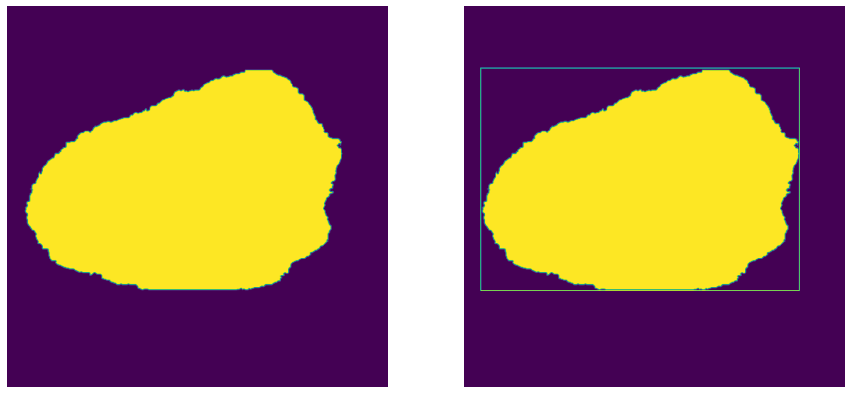

In [12]:
# Check that functions work properly:
for image in masksResized.take(1):
    probObj ,yMin, xMin, yMax, xMax = getPixelPositions(image)
    #Convert image to float32 (required for draw_bounding_boxes)
    boxImage = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Reshape to [batch, height, width, depth]
    boxImage = tf.reshape(image, shape=[1, 488, 488, 1])
    box = tf.stack([yMin/488, xMin/488, yMax/488, xMax/488], axis=0)
    # Reshape to [batch, num_bounding_boxes, 4]
    box = tf.reshape(box, shape=[1,1,4])
    box = tf.cast(box, tf.float32)
    colors = [[255.0, 0.0, 1.0]]
    newImage = tf.image.draw_bounding_boxes(boxImage, box, colors)
    display(image, newImage.numpy()[0])

In [13]:
# Find bounding box pixel positions for every image 
output = []
for image in masksResized:
    imageTest = image
    pixelPosition = getPixelPositions(image)
    # Get image class information... in this case it is easy. 
    pixelPosition.append(1)
    output.append(pixelPosition)

In [14]:
# Save bounding box information to text file
# This is useful, as the model may not work on different datasets, and will need to be optimized.
# Saving this information so we dont have to recalulate it is useful. 
with open('boundingBoxes.txt', 'w') as f:
    for box in output:
        f.write("%s\n" % ', '.join(map(str,box)))

In [16]:
# Save all images the have been reshaped:
# Again, saving these resized images is usefull incase we encounter issues and need to rerun this file. 
count = 0
for image in imagesResized:
    count += 1
    if count < 10:
        fileName = f"00000{count}"
    elif count < 100:
        fileName = f"0000{count}"
    elif count < 1000:
        fileName = f"000{count}"
    else:
        fileName = f"00{count}"
    tf.keras.preprocessing.image.save_img(f"new_images/{fileName}.jpg", image.numpy())

In [17]:
# Data-pre-pre-processing end
# One the images and bounding boxes have been saved we can now work on training the model.
# Once the above code has been run, it doesn't need to be run again. 

# Model Training

In [2]:
def load_jpeg(image, box):
    # Load the image turn into jpeg
    decoded = tf.io.read_file(image)
    imageTf = tf.image.decode_jpeg(decoded)
    # Normalize the image
    returnImage = tf.cast(imageTf, tf.float32) / 255.0
    # Reshape it to have the correct shape. 
    returnImage = tf.reshape(returnImage, (488,488,3))
    
    return returnImage, box

def convertToYTrue(box):
    # Takes ONE y_true box, and inserts this BOX to correct GRID POSITION
    row, col = box[1], box[2]
    updates = tf.constant([box[3:]])
    # Each cell with no bounding box still needs to have y_true information
    # Cells with no 'true' bounding box will be of the format [0, 0.9, 0.9, 0.9, 0.9, 0]
    idx = tf.constant([[[row, col, 0], [row, col, 1], [row, col, 2], [row, col, 3], [row, col, 4], [row, col, 5]]])
    output = tf.ones([7,7,6]) + [-1.0, -0.1, -.1, -.1, -.1, -1.0]
    output = tf.tensor_scatter_nd_add(output, idx, tf.zeros_like(updates) + [0, -0.9, -0.9, -0.9, -0.9, 0])
    output = tf.tensor_scatter_nd_add(output, idx, updates)
    return output
    
# Plots two given images
def display(imageOne, imageTwo):
    plt.figure(figsize=(15, 15))
    plt.subplot(1,2,1)
    plt.title("True Bounding Box")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imageOne))
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.title("Predicted Bounding Box")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imageTwo))
    plt.axis("off")
    plt.show()

#Convert true pixel indexes to yolo format
def convertToYoloFormat(pixelPositions, num_boxes=1, imageWidth=488, imageHeight=488):
    # Takes pixel positions in a format [xMin, xMax, yMin, yMax]
    # Format is [containsObj, center_x, center_y, width, height, classes...]
    cellHeight = imageHeight / S
    cellWidth = imageWidth / S
    returnBox = []
    countStart = 0
    countEnd = 1
    storage = []
    while countStart < num_boxes:
        _ ,yMin, xMin, yMax, xMax = pixelPositions[5*countStart:4*countEnd + 1]
        # Calculate the exact pixel index of the center of the box w.r.t the image
        pointX = (floor((xMax - xMin)/2)) + xMin
        pointY = (floor((yMax - yMin)/2)) + yMin
        # Calculate the center of the box w.r.t the cell
        centerX = (pointX - floor(pointX/cellWidth) * cellWidth)/cellWidth
        centerY = (pointY - floor(pointY/cellHeight) * cellHeight)/cellHeight
        # Calculate the dimensions w.r.t the image
        width = (xMax - xMin)/imageWidth
        height = (yMax - yMin)/imageHeight
        
        returnBox = returnBox + [_, centerX, centerY, width, height]
        countEnd += 1
        countStart += 1
    # Calculates where the bounding boxes cell is located
    colIndex = floor(pointX/cellWidth)
    rowIndex = floor(pointY/cellHeight)
    storage += colIndex, rowIndex
    
    return [num_boxes] + storage + returnBox + pixelPositions[5*countStart:]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Grab all the bounding box info
with open('/content/drive/My Drive/boundingBoxes.txt', 'r') as f:
    lines = f.readlines()
 
boxes = [[float(x) for x in line.strip().split(",")] for line in lines]

# Import image paths
imagesRaw = glob.glob("/content/drive/My Drive/new_images/*.jpg")
imagesRaw.sort()

import sys
sys.path.insert(0,'/content/drive/My Drive')

In [3]:
# Define the constants for the model
S = 7 # How the image will be divided, e.g. into S*S grid
B = 2 # Number of bounding boxes to be predicted PER CELl. 
C = 1 # Number of TRUE classes in the data set
BATCH_SIZE = 30

In [ ]:
# Import image paths
imagesRaw = glob.glob("./new_images/*.jpg")
imagesRaw.sort()

# Grab all the bounding box info
with open('boundingBoxes.txt', 'r') as f:
    lines = f.readlines()

# Convert a txt file, where each line is the true bounxing boxes for an image,
boxes = [[float(x) for x in line.strip().split(",")] for line in lines]

In [6]:
# Convert boxes to yolo format:
convertedBoxes = [convertToYoloFormat(box) for box in boxes]
# Convert the convertedBoxes to the same format as y_pred
yTrue = [convertToYTrue(box) for box in convertedBoxes]
# Create a new dataset, pairing images paths and respective boxes
imageDataSet = tf.data.Dataset.from_tensor_slices((imagesRaw, yTrue))
# Shuffle the data
imageDataSet = imageDataSet.shuffle(1000)
# Map the paths to turn into images
entireSet = imageDataSet.map(load_jpeg)

In [7]:
# Divide the dataset into train, test and validation
trainSize = int(0.8 * 2594)
valSize = int(0.1 * 2594)
train = entireSet.take(trainSize)
temp = entireSet.skip(trainSize)
test = temp.skip(valSize)
validation = temp.take(valSize)

In [8]:
# Create batches:
train_batches = train.batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = train.batch(1)

In [9]:
import model

In [ ]:
yoloModel = model.YoloV1()
yoloModel.compileModel()
history = yoloModel.runModel(train_batches, validation_batches, epochs=60)

Epoch 1/60
104/104 [==============================] - 727s 7s/step - loss: 1955.5687 - jaccardIndex: 0.1410 - val_loss: 65643468.0000 - val_jaccardIndex: 0.0522
Epoch 2/60
104/104 [==============================] - 80s 776ms/step - loss: 245.0526 - jaccardIndex: 0.1293 - val_loss: 439116096.0000 - val_jaccardIndex: 0.0000e+00
Epoch 3/60
104/104 [==============================] - 52s 500ms/step - loss: 30.5610 - jaccardIndex: 0.2636 - val_loss: 1087248.0000 - val_jaccardIndex: 0.1616
Epoch 4/60
104/104 [==============================] - 50s 483ms/step - loss: 10.6049 - jaccardIndex: 0.2038 - val_loss: 1.2324 - val_jaccardIndex: 0.4071
Epoch 5/60
104/104 [==============================] - 49s 473ms/step - loss: 7.2294 - jaccardIndex: 0.1660 - val_loss: 3184.6948 - val_jaccardIndex: 0.0547
Epoch 6/60
104/104 [==============================] - 49s 468ms/step - loss: 5.1031 - jaccardIndex: 0.1932 - val_loss: 608.5759 - val_jaccardIndex: 0.0000e+00
Epoch 7/60
104/104 [=======================

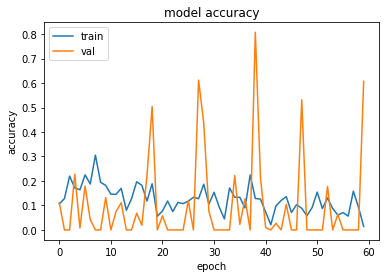

In [ ]:
plt.plot(history.history['jaccardIndex'])
plt.plot(history.history['val_jaccardIndex'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

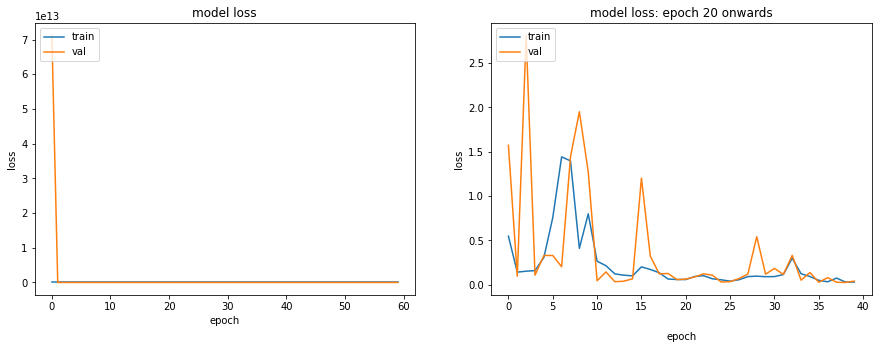

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.title('model loss: epoch 20 onwards')
plt.ylabel('loss')
plt.xlabel('epoch', labelpad=20)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
result = yoloModel.evaluateData(test_batches)

260/260 [==============================] - 10s 22ms/step - loss: 0.0500 - jaccardIndex: 0.0201


In [ ]:
total = 0
for image, box in test_batches.take(260):
  y_pred = tf.math.abs(model.predict(image))
  y_true = box
  image = image
  total += float(jaccardIndex(y_true, y_pred))
print(total/260)

0.793935227737977


In [ ]:
y_true = tf.reshape(y_true[...,:5], [-1,S,S,1,5])
y_pred = tf.reshape(y_pred[...,:B*5], [-1,S,S,B,5])

# Get the true bounding box. 
# This first finds the max confidence, then finds which have a confidence equal to that max, 
# then grabs the box with that max
y_true_box_loc = (tf.where(tf.equal(y_true[...,0], tf.math.reduce_max(y_true[...,0]))))[0]
y_true_box = tf.gather_nd(y_true, y_true_box_loc)
# Get the bounding box that has the highest confidence + location in grid. 
y_pred_box_loc = (tf.where(tf.equal(y_pred[...,0], tf.math.reduce_max(y_pred[...,0]))))[0]
y_pred_box = tf.gather_nd(y_pred, y_pred_box_loc)
 
trueBox = tf.stack(yoloModel.convertYoloBoxToStandard(y_true_box, y_true_box_loc))
predBox = tf.stack(yoloModel.convertYoloBoxToStandard(y_pred_box, y_pred_box_loc))

In [ ]:
print(predBox)
print(trueBox)

tf.Tensor([141. 139. 344. 347.], shape=(4,), dtype=float32)
tf.Tensor([ 48. 102. 434. 396.], shape=(4,), dtype=float32)


In [ ]:
tBox = tf.reshape(trueBox, shape=[1,1,4])
pBox = tf.reshape(predBox, shape=[1,1,4])
tColor = [[1.0, 0.0, 0.0]]
pColor = [[0.0, 0.0, 1.0]]
image = tf.cast(image, tf.float32)
tImage = tf.image.draw_bounding_boxes(image, tBox/488, tColor)
pImage = tf.image.draw_bounding_boxes(image, pBox/488, pColor)

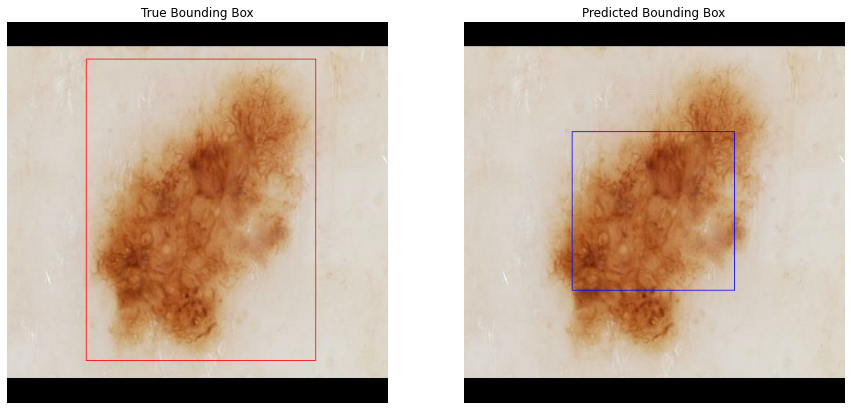

In [ ]:
display(tImage.numpy()[0], pImage.numpy()[0])